In [21]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import time
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mpl_toolkits.mplot3d import Axes3D

In [22]:
source = './formatedYears.parquet'
data = pq.read_table(source='./formatedYears.parquet').to_pandas()

profiles = data['data']


x1 = []
x2 = []
Y = []


for data in profiles:
    auxi = data
    valor = 0
    for val in auxi[1:]:
        valor = valor + val
    x1.append(valor)
    x2.append(len(auxi))
    Y.append(auxi[0])
    

data = {
    'anos_trabalhados': x1,
    'quantidade_empregos': x2,
    'tempo_proximo_emprego': Y
}

df = pd.DataFrame(data)


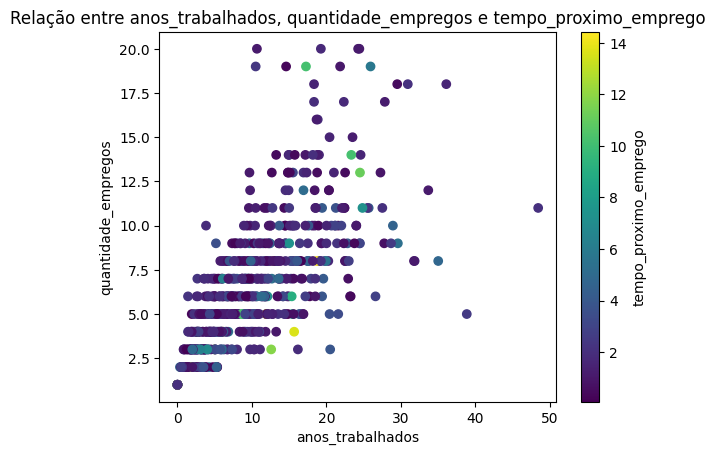

In [23]:
# Plotando os dados
plt.scatter(df['anos_trabalhados'], df['quantidade_empregos'], c=df['tempo_proximo_emprego'], cmap='viridis')
plt.colorbar(label='tempo_proximo_emprego')
plt.xlabel('anos_trabalhados')
plt.ylabel('quantidade_empregos')
plt.title('Relação entre anos_trabalhados, quantidade_empregos e tempo_proximo_emprego')

# Mostrando o gráfico
plt.show()

In [24]:
# Separando as features e o target
X = df[['anos_trabalhados', 'quantidade_empregos']].values
y = df['tempo_proximo_emprego'].values

# Padronizando os dados
def standardize_data(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X_standardized = (X - mean) / std
    return X_standardized, mean, std

X, mean, std = standardize_data(X)

In [25]:
class SVR:
    def __init__(self, epsilon=0.1, C=1.0, learning_rate=0.001, n_iter=1000):
        self.epsilon = epsilon
        self.C = C
        self.learning_rate = learning_rate
        self.n_iter = n_iter

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0
        
        # Gradient Descent
        for _ in range(self.n_iter):
            for i in range(n_samples):
                y_pred = np.dot(X[i], self.w) + self.b
                if y[i] - y_pred > self.epsilon:
                    self.w += self.learning_rate * (self.C * (y[i] - y_pred - self.epsilon) * X[i])
                    self.b += self.learning_rate * (self.C * (y[i] - y_pred - self.epsilon))
                elif y_pred - y[i] > self.epsilon:
                    self.w -= self.learning_rate * (self.C * (y_pred - y[i] - self.epsilon) * X[i])
                    self.b -= self.learning_rate * (self.C * (y_pred - y[i] - self.epsilon))

    def predict(self, X):
        return np.dot(X, self.w) + self.b
    
    def decision_function(self, X):
        return np.dot(X, self.w) + self.b
    
    def calculate_confidence(self, X, y):
        y_pred = self.predict(X)
        residuals = np.abs(y - y_pred)
        confidence = 1 - residuals / np.max(residuals)  # Normalizar a confiança
        return confidence



In [26]:
def validacao_cruzada(X, y, model, num_grupos):
    num_amostras = len(X)
    tamanho_grupo = num_amostras // num_grupos

    mse_scores = []
    mae_scores = []
    r2_scores = []
    for grupo in range(num_grupos):
        # Dividir os dados em conjunto de treino e teste para este grupo
        inicio = grupo * tamanho_grupo
        fim = (grupo + 1) * tamanho_grupo
        
        teste_caracteristicas = X[inicio:fim]
        teste_alvo = y[inicio:fim]
        
        treino_caracteristicas = np.concatenate((X[:inicio], X[fim:]), axis=0)
        treino_alvo = np.concatenate((y[:inicio], y[fim:]), axis=0)
        
        model.fit(treino_caracteristicas, treino_alvo)
        y_pred = model.predict(teste_caracteristicas)
        
        print(len(treino_caracteristicas))
        print(len(teste_caracteristicas))
        valoresReaisVsPrevisoes(model, teste_alvo, teste_caracteristicas, y_pred)
        mse_scores.append(mean_squared_error(teste_alvo, y_pred))
        mae_scores.append(mean_absolute_error(teste_alvo, y_pred))
        r2_scores.append(r2_score(teste_alvo, y_pred))
    
    print(f'Mean MSE: {np.mean(mse_scores)}, Std MSE: {np.std(mse_scores)}')
    print(f'Mean MAE: {np.mean(mae_scores)}, Std MAE: {np.std(mae_scores)}')
    print(f'Mean R2: {np.mean(r2_scores)}, Std R2: {np.std(r2_scores)}')
    return mse_scores, mae_scores, r2_scores
    

In [27]:

def valoresReaisVsPrevisoes(svr, valores_reais, test_caracteristicas, valores_previstos):
    
    plt.figure(figsize=(8, 6))
    plt.scatter(valores_reais, valores_previstos, color='blue', label='Previsões')
    plt.plot([min(valores_reais), max(valores_reais)], [min(valores_reais), max(valores_reais)], color='red', linestyle='--', label='Linha de Identidade')
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Previstos')
    plt.title('Gráfico de Dispersão: Valores Reais vs. Valores Previstos')
    plt.legend()
    plt.grid(True)
    plt.show()
    confidence = svr.calculate_confidence(test_caracteristicas, valores_reais)
    #print(f"Confiança das previsões: {confidence}")

    # Gráfico de Dispersão
    plt.figure(figsize=(10, 6))
    plt.scatter(valores_previstos, confidence, c='blue', marker='o')
    plt.xlabel('Valores Preditos')
    plt.ylabel('Confiança')
    plt.title('Confiança das Previsões em Relação aos Valores Preditos')
    plt.show()

    
    # Histograma da Confiança
    plt.figure(figsize=(10, 6))
    plt.hist(confidence, bins=10, color='green', edgecolor='black')
    plt.xlabel('Confiança')
    plt.ylabel('Número de Previsões')
    plt.title('Distribuição da Confiança das Previsões')
    plt.show()

528
131


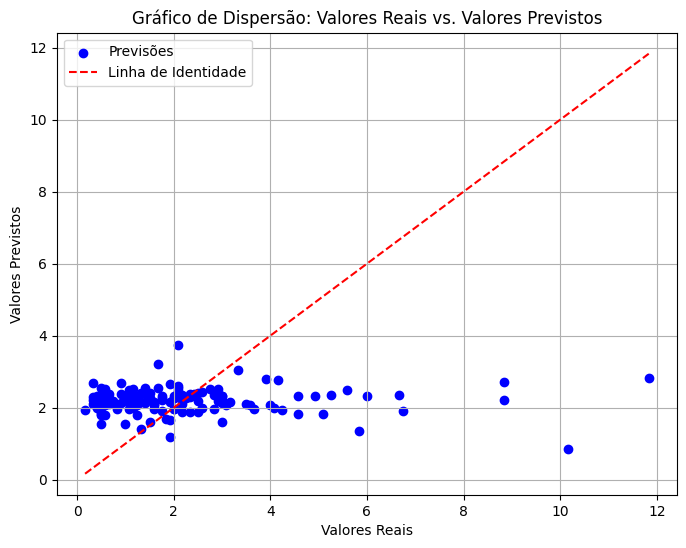

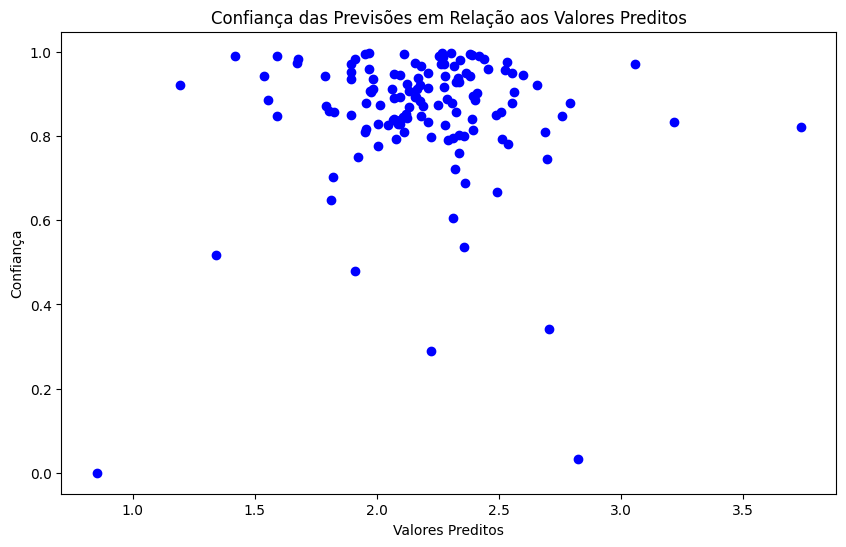

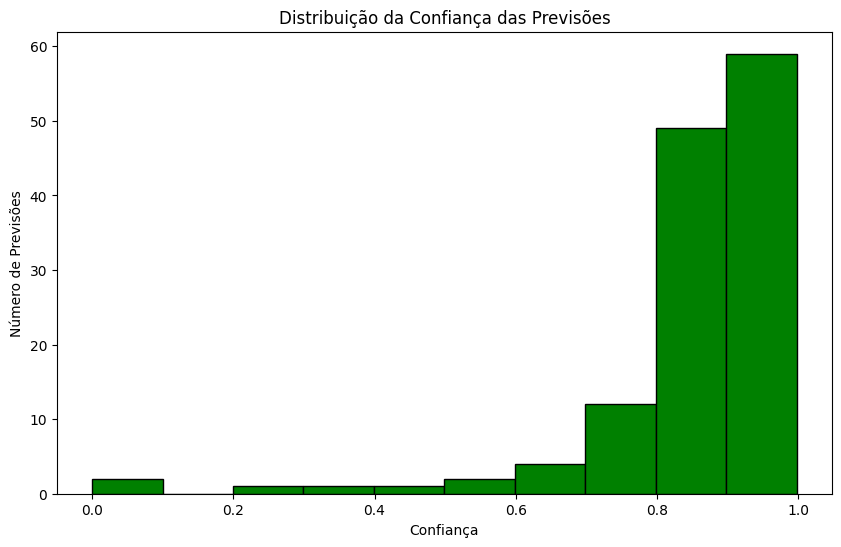

528
131


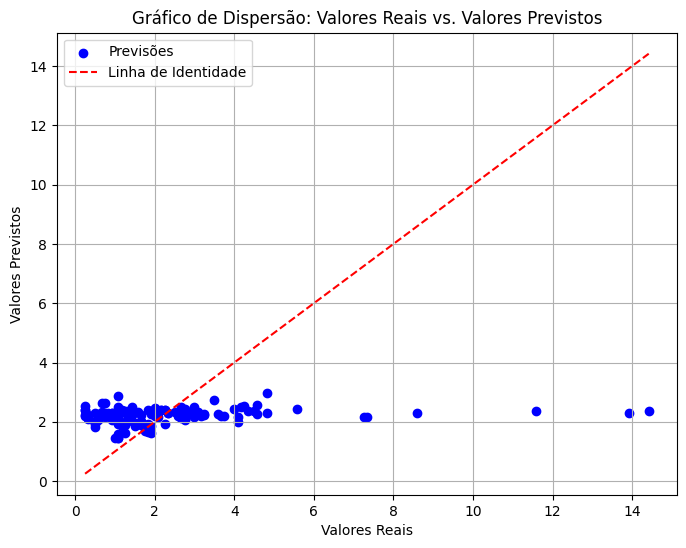

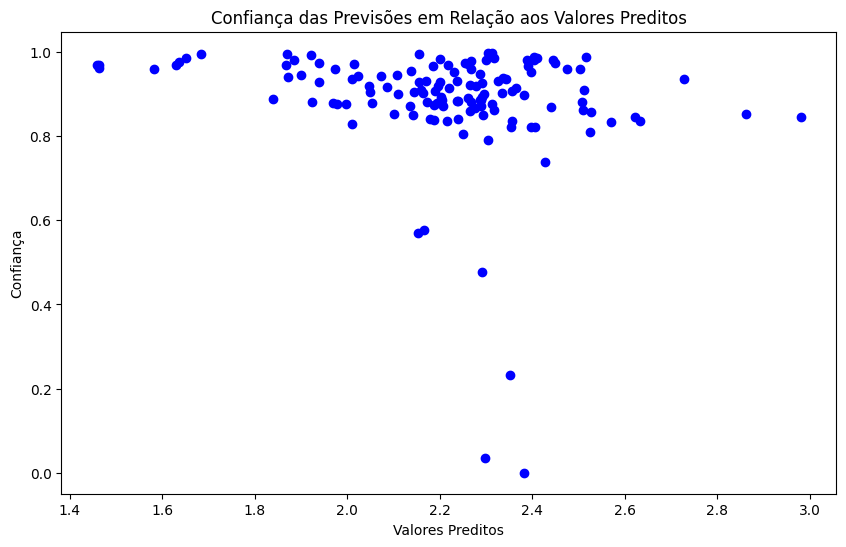

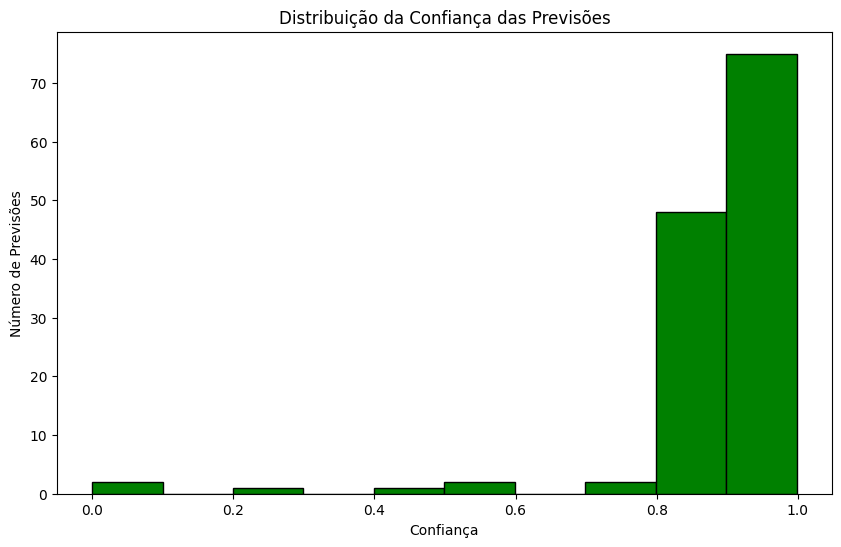

528
131


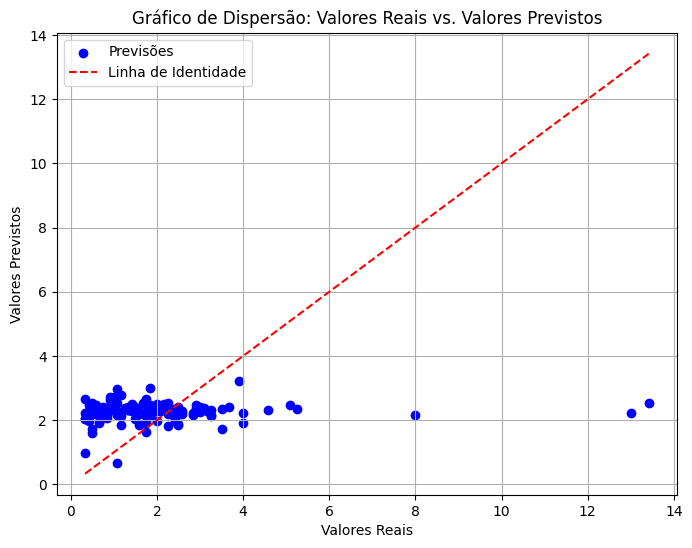

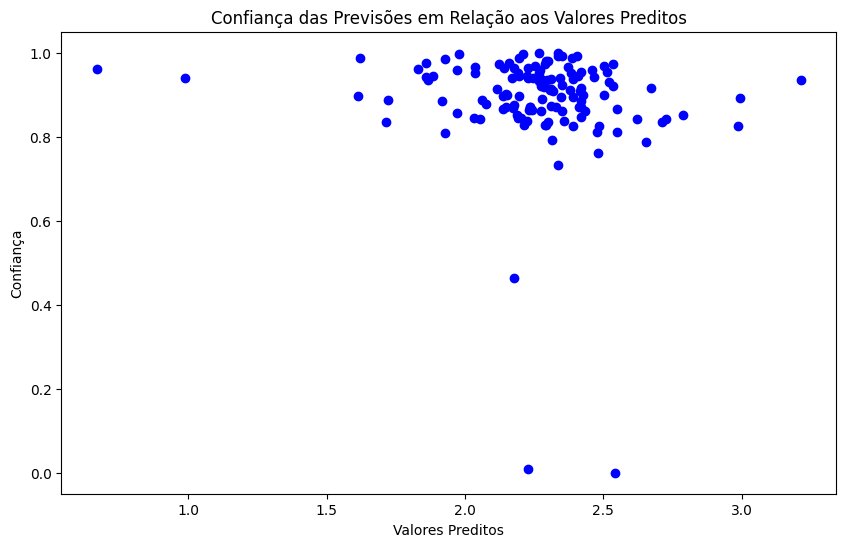

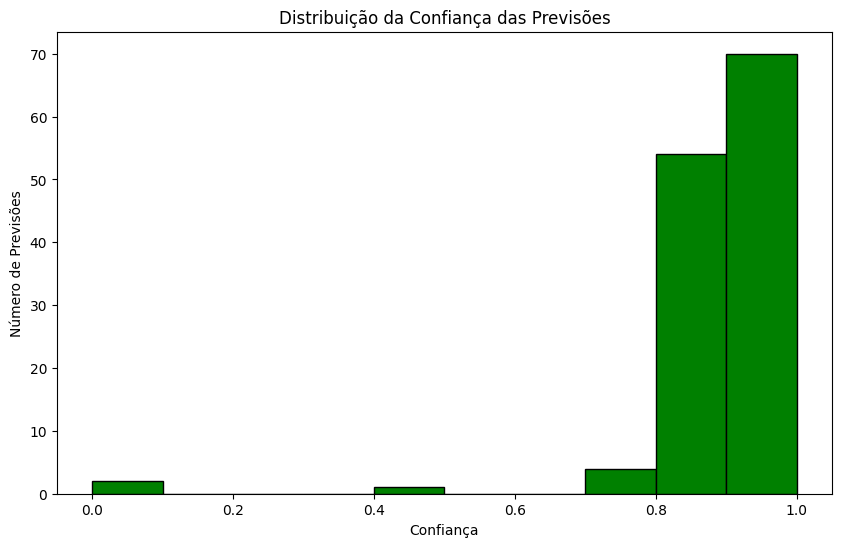

528
131


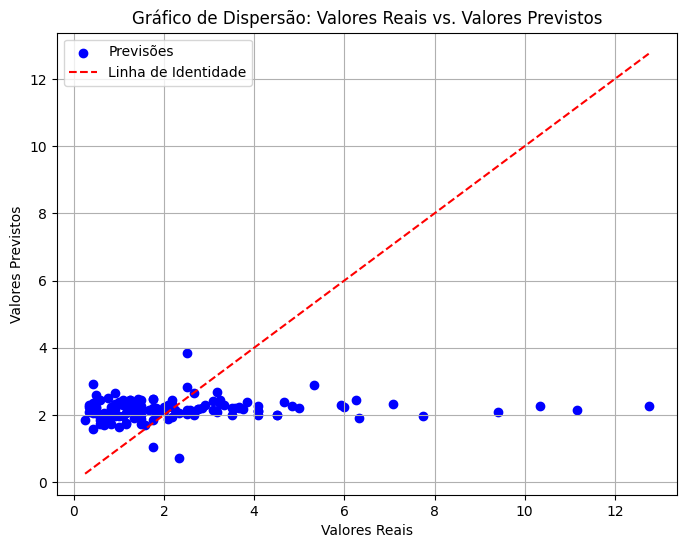

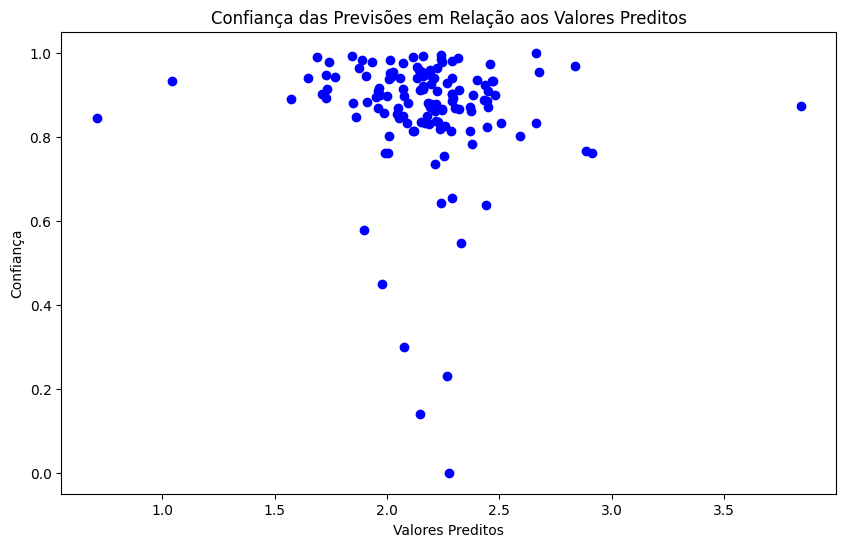

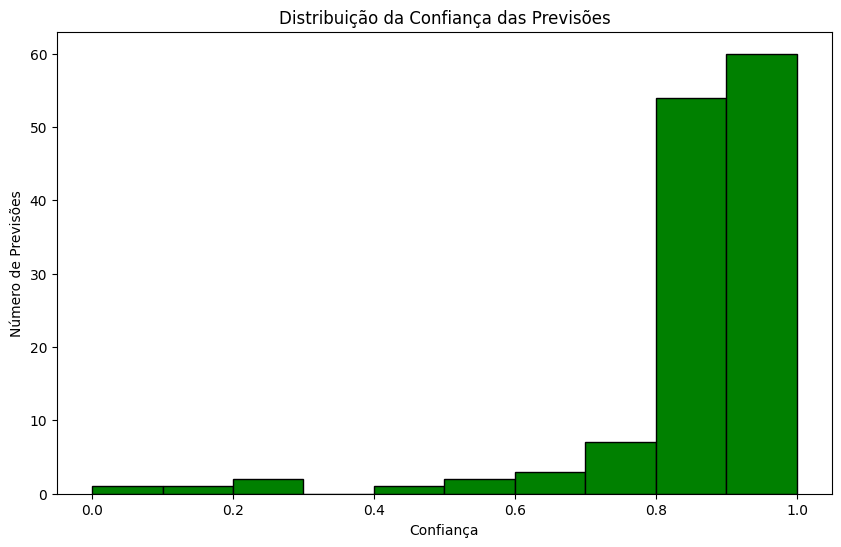

528
131


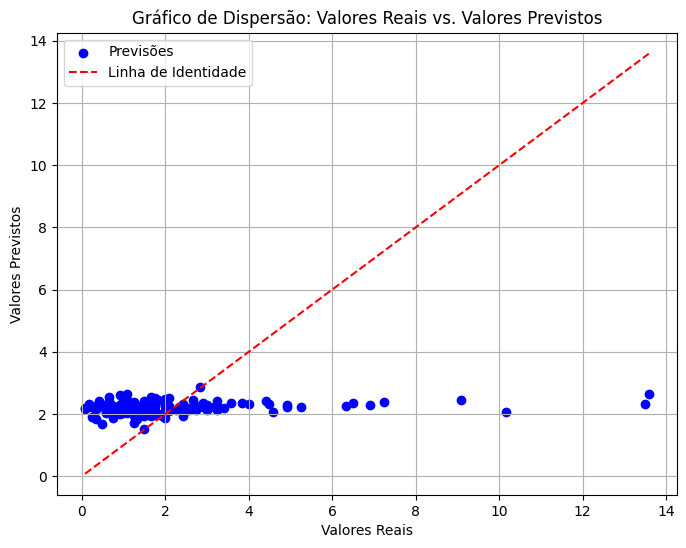

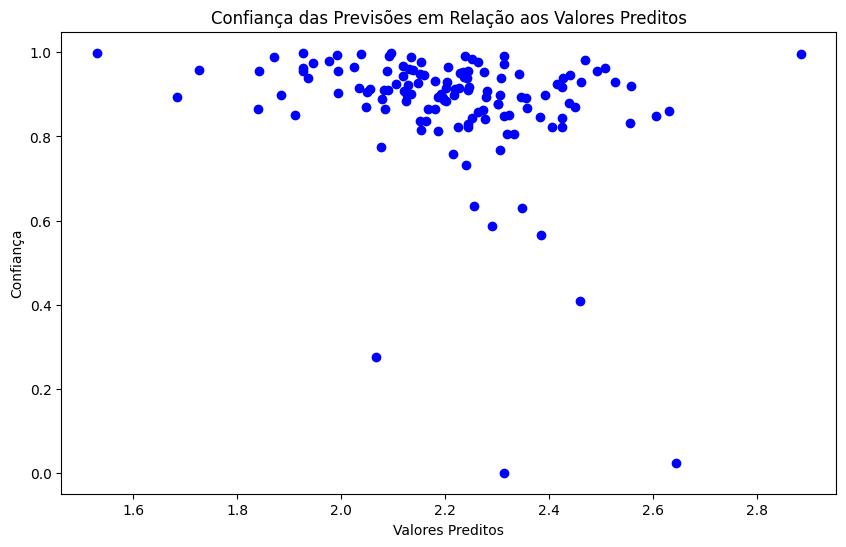

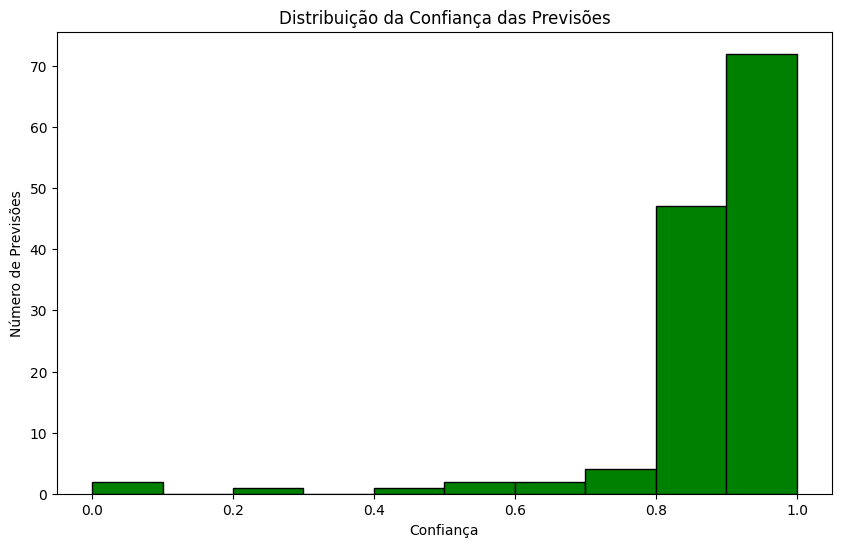

Mean MSE: 4.363018255695567, Std MSE: 0.563218505469891
Mean MAE: 1.356387570576602, Std MAE: 0.08740298256315153
Mean R2: 0.0022192351583215863, Std R2: 0.028495342234586152


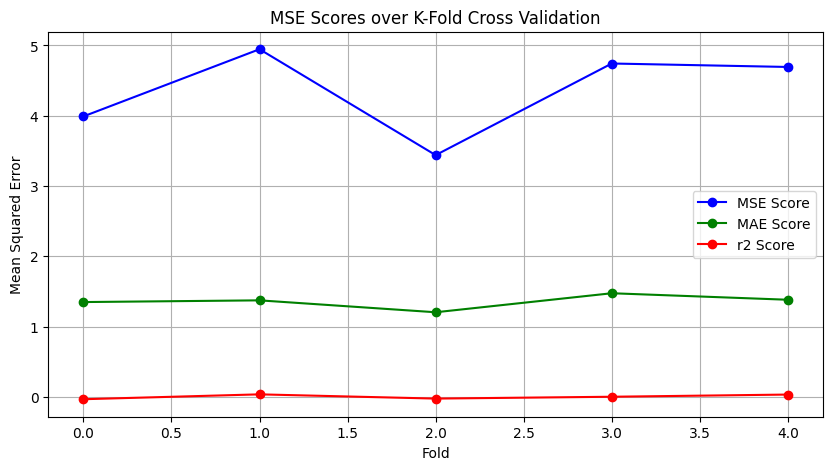

In [28]:


# Instanciando o modelo SVR
svr = SVR(epsilon=0.1, C=1.0,  learning_rate=0.001, n_iter=1000)

# Realizando a validação cruzada
mse_scores, mae_scores, r2_scores = validacao_cruzada(X, y, svr, 5)



# Plotando as pontuações MSE
plt.figure(figsize=(10, 5))
plt.plot(mse_scores, marker='o', linestyle='-', color='b', label='MSE Score')
plt.plot(mae_scores, marker='o', linestyle='-', color='g', label='MAE Score')
plt.plot(r2_scores, marker='o', linestyle='-', color='r', label='r2 Score')
plt.title('MSE Scores over K-Fold Cross Validation')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

In [29]:

result = svr.predict([2.667, 4])

print(result)

1.7112657879460984


In [175]:

result = svr.predict([5.1666, 5])

print(result)

2.199688569101695
